CSC 420 A2

In [ ]:
# import Torch packages and its submodules
import torch
from torch import nn, optim,cuda

# import TorchVision and its submodules
import torch.nn.functional as F
from torchvision import datasets, transforms

# import other packages
import numpy as np
import math

import matplotlib
from matplotlib import pyplot as plt


import os
os.mkdir('/content/models')

In [ ]:
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [ ]:
# Timing utility
from timeit import default_timer as timer

# Part I load data and preprocessing

if the data has already been split in google drive, skip the steps

split the data into 15000 training, 1000 validation, and rest for testing

In [ ]:
!pip install split-folders
!pip install split-folders tqdm

In [ ]:
import splitfolders

In [ ]:
!tar xvzf "/content/drive/MyDrive/notMNIST_small.tar.gz" -C "/content/"

In [ ]:
train = 15000/18720
val = 1000/18720
test = 2720/18720
splitfolders.ratio("/content/notMNIST_small", output="/content/data", seed=1337, ratio=(train ,val, test), group_prefix=None)

Copying files: 18726 files [00:03, 5238.55 files/s]


Load data

In [ ]:
train_path = "/content/data/train"
valid_path = "/content/data/val"
test_path = "/content/data/test"

We have enough data for training, and it does not make sense to rotate the images (for example, H and I may fail to be recognized after rotatoin). It would be helpful to normalize the images

since the images we have here are all black and white, the images are transformed into greyscale

In [ ]:
!pip install nonechucks

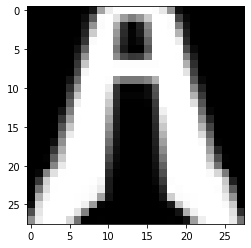

In [ ]:
import nonechucks as nc

#transformation to tensor and with normalization
image_transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1),transforms.Normalize((0.5,), (0.5,))])

#batch size
batch = 64

# Download and load the training, validation and test data
train_set = datasets.ImageFolder(root=train_path, transform=image_transform)
train_set = nc.SafeDataset(train_set)
train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch, shuffle=True)

val_set = datasets.ImageFolder(root=valid_path, transform=image_transform)
val_set = nc.SafeDataset(val_set)
val_loader = torch.utils.data.DataLoader(val_set, batch_size= batch, shuffle=True)

test_set = datasets.ImageFolder(root=test_path, transform=image_transform)
test_set = nc.SafeDataset(test_set)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= batch, shuffle=True)

#print(train_set[1][0][0][0])

plt.imshow(train_set[1][0][0], cmap = 'gray')
plt.show()
print(train_set)
print(val_set)
print(test_set)


# Setting up the models

The following class define the neural network
here we use 

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        #note that bias = True by default
       
        #num_of_layers = 100
        #num_of_layers = 500
        num_of_layers = 1000
        
        
        ## 1000 layers
        # Inputs to hidden layer 784 = 28x28x1
        self.hidden = nn.Linear(784, num_of_layers)
        # Output layer, 10 letters
        self.output = nn.Linear(num_of_layers, 10)
        '''
        # Inputs to hidden layer 784 = 28x28x1
        self.hidden_1 = nn.Linear(784, 500)
        self.hidden_2 = nn.Linear(500, 500)
        # Output layer, 10 letters
        self.output = nn.Linear(500, 10)
        '''

        # ReLU activation and softmax on the output 
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        self.drop = nn.Dropout(0.5)

    
    def forward(self, x):
        x = self.hidden(x)
        x = self.drop(x)       
        x = self.relu(x)
        x = self.output(x)
        x = self.softmax(x)
        return x
    '''
    def forward(self, x):
        x = self.hidden_1(x)
        x = self.relu(x)
        x = self.hidden_2(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.softmax(x)
    
        return x
    '''


# setting up training


function for calculating accuracy

In [ ]:
def get_acc(results, targets):

    accuracy = 0

    # get the predictions: argmax etc.
    ps = torch.exp(results)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == targets.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))

    return accuracy

function for training the model

move the model to GPU

notes from pytorch: If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. Parameters of a model after .cuda() will be different objects with those before the call.

remember later to put the training data also to GPU

In [ ]:
#get the progress
from tqdm import tqdm

def train(model, lr, epochs, stop_threshold, train_data, val_data, test_data, PATH, cal_error_train=False, cal_test_data=False):

    if train_on_gpu:
        model = model.to('cuda')

    #loss
    criterion = nn.CrossEntropyLoss()
    # Optimizers and a learning rate
    # use the stochastic gradient descent
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.0001)

    model_data = []
    train_losses = []
    val_losses = []
    train_error = []
    val_error = [] 
    test_error = []

    start = timer()
    epoch = 0
    min_val_loss = np.Inf
    count_worse = 0

    for e in range(epochs):
        epoch += 1
        epoch_start = timer()

        #training
        model.train()
        train_loss = 0
        train_acc = 0
        for ii, (images, labels) in enumerate(train_data):
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            images = images.view(images.shape[0], -1)
            #print(labels.shape[0][0])
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            train_loss += loss

            #update the parameters
            optimizer.step()

            if cal_error_train:
                results = model(images)
                train_acc += get_acc(results, labels)

        train_loss = train_loss/len(train_data)
        if cal_error_train:
            train_acc = train_acc / len(train_data)

        
        with torch.no_grad():
            #calculate validation loss for each epoch
            model.eval()
            valid_acc = 0
            valid_loss = 0
            for ii, (images, labels) in enumerate(val_data):
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                images = images.view(images.shape[0], -1)

                results = model(images)
                loss = criterion(results, labels)
                valid_loss += loss
                valid_acc += get_acc(results, labels)
            
            valid_acc = valid_acc / len(val_data)
            valid_loss =  valid_loss / len(val_data)

            #calculate test error for each epoch
            test_acc = 0
            if cal_test_data:
                model.eval()
                for ii, (images, labels) in enumerate(test_data):
                    if train_on_gpu:
                        images, labels = images.cuda(), labels.cuda()
                    images = images.view(images.shape[0], -1)

                    results = model(images)
                    test_acc += get_acc(results, labels)
                
                test_acc = test_acc / len(test_data)

            #append all calculated data for plots
            train_losses.append(train_loss)
            val_losses.append(valid_loss)
            train_error.append(1-train_acc)
            val_error.append(1-valid_acc)
            test_error.append(1-test_acc)
 
            print("Epoch: {} \tTraining loss: {:.6f}\t "
                "Valid accuracy: {}\t test accuracy: {}".format(epoch, train_loss, valid_acc, test_acc))
            print("Time on epoch: ", str(timer()-epoch_start))

            if valid_loss < min_val_loss:
                min_val_loss = valid_loss
                count_worse = 0
            else:
                count_worse += 1
                if count_worse >= stop_threshold:
                    print("--------------------------------------")
                    print("early stopping!")
                    torch.save({
                            'epochs': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': train_losses[len(train_losses)-1]
                            }, PATH)

                    model_data = [train_losses, val_losses, train_error, val_error, test_error]

                    print("overall time spent: {} ".format(timer()-start))
                    return model, model_data        


    

    torch.save({
                'epochs': epoch,
                'model_state_dict': model2.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_losses[len(train_losses)-1]
                }, PATH)

    model_data = [train_losses, val_losses, train_error, val_error, test_error]

    print("overall time spent: {} ".format(timer()-start))

    return model, model_data        


error note:

RuntimeError: CUDA error: CUBLAS_STATUS_INVALID_VALUE when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

it means that the dimension does not match

Funtion for generating plots

In [ ]:
def plotting(model_data, title_loss, title_error, train_error = False, test_error = False):
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(model_data[0])), 
            model_data[0], 
            marker='.',
            markersize=10,
            label='training loss')
    plt.plot(range(len(model_data[0])), 
            model_data[1], 
            marker='.',
            markersize=10,
            label='validation loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Averaged loss')
    plt.title(title_loss)
    plt.savefig('/content/'+title_loss)

    plt.figure(figsize=(8, 6))
    if  train_error:
        plt.plot(range(len(model_data[0])), 
                model_data[2], 
                marker='.',
                markersize=10,
                label='training error')
    plt.plot(range(len(model_data[0])), 
            model_data[3], 
            marker='.',
            markersize=10,
            label='validation error')
    if test_error:
        plt.plot(range(len(model_data[0])), 
                model_data[4], 
                marker='.',
                markersize=10,
                label='test error')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Percentage of error')
    plt.title(title_error)
    plt.savefig('/content/'+title_error)

# training and results


# Task II

Network(
  (hidden): Linear(in_features=784, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
<generator object Module.parameters at 0x7fbbeb2d6d50>
Epoch: 1 	Training loss: 1.680048	 Valid accuracy: 0.8667968511581421	 test accuracy: 0.8783659934997559
Time on epoch:  0.6695080579997921
Epoch: 2 	Training loss: 1.575683	 Valid accuracy: 0.8794921636581421	 test accuracy: 0.8901277780532837
Time on epoch:  0.6779401140001937
Epoch: 3 	Training loss: 1.561954	 Valid accuracy: 0.884570300579071	 test accuracy: 0.8973951935768127
Time on epoch:  0.6563655840000138
Epoch: 4 	Training loss: 1.553506	 Valid accuracy: 0.884765625	 test accuracy: 0.896515429019928
Time on epoch:  0.6676217199997154
Epoch: 5 	Training loss: 1.547015	 Valid accuracy: 0.8880859613418579	 test accuracy: 0.9053893685340881
Time on epoch:  0.6831518070002858
Epoch: 6 	Training loss: 1.542459	 Valid accuracy: 0.88222658634185

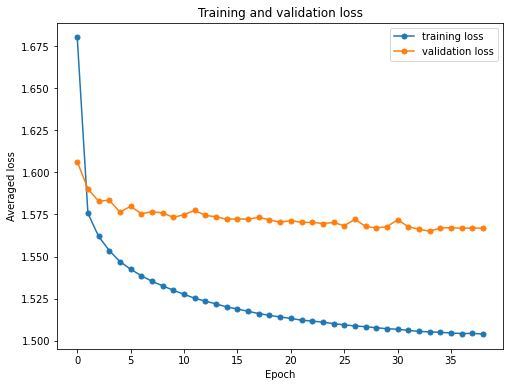

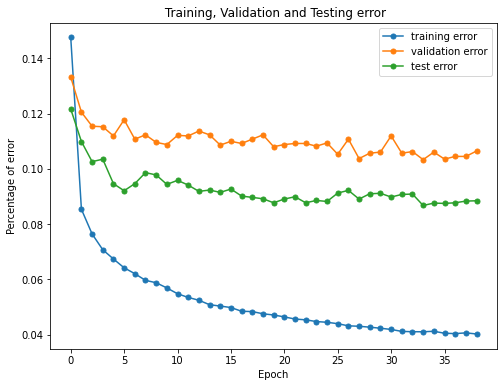

In [ ]:
m1 = Network()
print(m1)
print(m1.parameters())

m1, m1_data = train(m1, lr= 0.2, epochs= 1000 , stop_threshold = 5,
                          train_data=train_loader, val_data=val_loader, test_data=test_loader,
                          PATH = '/content/models/m1000-0.2.py',
                          cal_error_train=True, cal_test_data=True)

#print the errors when stopped
print("Training error: {}, validatoin error: {}, test error: {}".format(m1_data[2][len(m1_data[0])-1], m1_data[3][len(m1_data[0])-1],m1_data[4][len(m1_data[0])-1]))

#plots
plotting(m1_data, 'Training and validation loss', ' Training, Validation and Testing error', train_error=True, test_error=True)

#Testing
accuracy = 0
for images, labels in test_loader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    images = images.view(images.shape[0], -1)
    output = m1(images)
    accuracy += get_acc(output, labels)

print("Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))


# Task III

Network(
  (hidden): Linear(in_features=784, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
<generator object Module.parameters at 0x7fbbeade59d0>
Epoch: 1 	Training loss: 1.688630	 Valid accuracy: 0.8548828363418579	 test accuracy: 0.8679428696632385
Time on epoch:  0.6318942339994464
Epoch: 2 	Training loss: 1.577160	 Valid accuracy: 0.8779296875	 test accuracy: 0.8896304965019226
Time on epoch:  0.6209113170007186
Epoch: 3 	Training loss: 1.562449	 Valid accuracy: 0.8734375238418579	 test accuracy: 0.8924226760864258
Time on epoch:  0.6066880819998914
Epoch: 4 	Training loss: 1.554739	 Valid accuracy: 0.8857421875	 test accuracy: 0.9001682996749878
Time on epoch:  0.6298563529999228
Epoch: 5 	Training loss: 1.548442	 Valid accuracy: 0.882617175579071	 test accuracy: 0.8984853029251099
Time on epoch:  0.6608391740001025
Epoch: 6 	Training loss: 1.543848	 Valid accuracy: 0.885937511920929	 tes

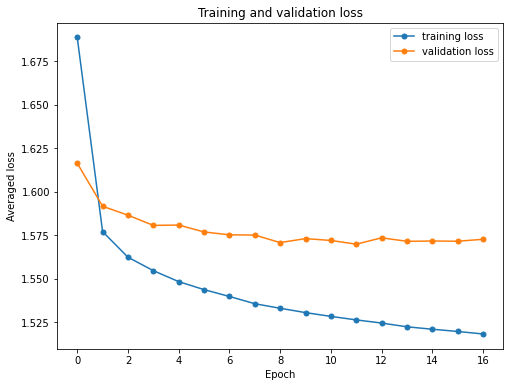

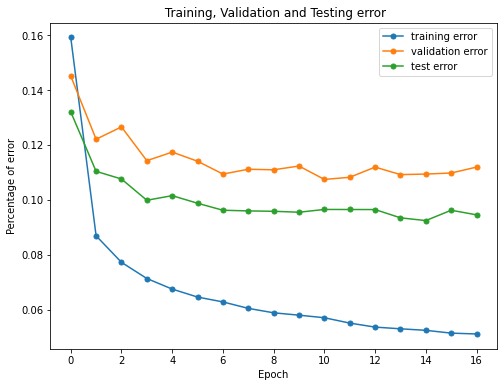

In [ ]:
m_100 = Network()
print(m_100)
print(m_100.parameters())

m_100, m_100_data = train(m_100, lr= 0.25, epochs= 1000 , stop_threshold = 5,
                          train_data=train_loader, val_data=val_loader, test_data=test_loader,
                          PATH = '/content/models/m100-0.25.py',
                          cal_error_train=True, cal_test_data=True)


best_val_error = min(m_100_data[3])

#print the errors when stopped
print("Best vaidation error {}".format(best_val_error))

#plots
plotting(m_100_data, 'Training and validation loss', ' Training, Validation and Testing error', train_error=True, test_error=True)

#Testing
accuracy = 0
for images, labels in test_loader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    images = images.view(images.shape[0], -1)
    output = m_100(images)
    accuracy += get_acc(output, labels)

print("The final Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Network(
  (hidden): Linear(in_features=784, out_features=500, bias=True)
  (output): Linear(in_features=500, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
<generator object Module.parameters at 0x7fbbeb345bd0>
Epoch: 1 	Training loss: 1.667777	 Valid accuracy: 0.869921863079071	 test accuracy: 0.8780025839805603
Time on epoch:  0.698828677000165
Epoch: 2 	Training loss: 1.569492	 Valid accuracy: 0.882617175579071	 test accuracy: 0.8963050842285156
Time on epoch:  0.6431076420003592
Epoch: 3 	Training loss: 1.557407	 Valid accuracy: 0.889843761920929	 test accuracy: 0.8998240232467651
Time on epoch:  0.6509193490001053
Epoch: 4 	Training loss: 1.548707	 Valid accuracy: 0.8828125	 test accuracy: 0.8928816914558411
Time on epoch:  0.6772114339992186
Epoch: 5 	Training loss: 1.542727	 Valid accuracy: 0.891406238079071	 test accuracy: 0.9032091498374939
Time on epoch:  0.6249578520000796
Epoch: 6 	Training loss: 1.538043	 Valid accuracy: 0.8828125	 test accurac

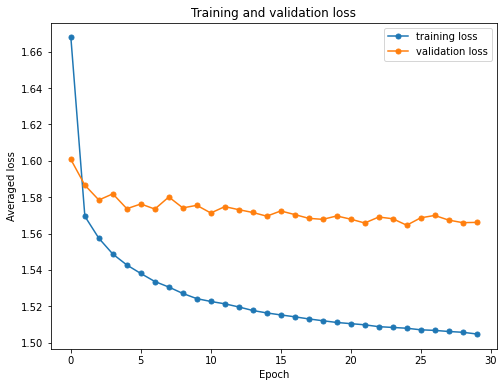

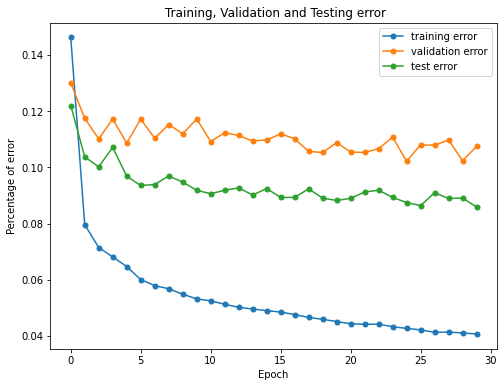

In [ ]:
m_500 = Network()
print(m_500)
print(m_500.parameters())

m_500, m_500_data = train(m_500, lr= 0.3, epochs= 1000 , stop_threshold = 5,
                          train_data=train_loader, val_data=val_loader, test_data=test_loader,
                          PATH = '/content/models/m500-0.3.py',
                          cal_error_train=True, cal_test_data=True)


best_val_error = min(m_500_data[3])

#print the errors when stopped
print("Best vaidation error {}".format(best_val_error))

#plots
plotting(m_500_data, 'Training and validation loss', ' Training, Validation and Testing error', train_error=True, test_error=True)

#Testing
accuracy = 0
for images, labels in test_loader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    images = images.view(images.shape[0], -1)
    output = m_500(images)
    accuracy += get_acc(output, labels)

print("The final Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Network(
  (hidden): Linear(in_features=784, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
<generator object Module.parameters at 0x7fbbeac77ed0>
Epoch: 1 	Training loss: 1.658973	 Valid accuracy: 0.870312511920929	 test accuracy: 0.8882917165756226
Time on epoch:  0.730218953000076
Epoch: 2 	Training loss: 1.568878	 Valid accuracy: 0.884570300579071	 test accuracy: 0.8964197635650635
Time on epoch:  0.674214261999623
Epoch: 3 	Training loss: 1.555609	 Valid accuracy: 0.8892577886581421	 test accuracy: 0.8977203369140625
Time on epoch:  0.6637225539998326
Epoch: 4 	Training loss: 1.546377	 Valid accuracy: 0.8843749761581421	 test accuracy: 0.9030752778053284
Time on epoch:  0.6688178710001011
Epoch: 5 	Training loss: 1.539850	 Valid accuracy: 0.8890625238418579	 test accuracy: 0.9072062373161316
Time on epoch:  0.6520988210004361
Epoch: 6 	Training loss: 1.535216	 Valid accuracy: 0.884960949

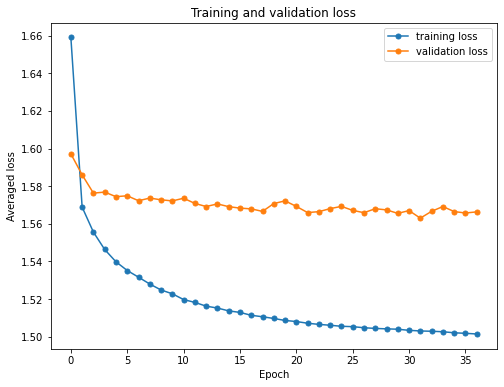

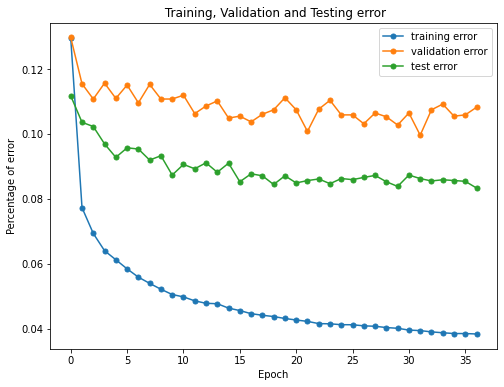

In [ ]:
m_1000 = Network()
print(m_1000)
print(m_1000.parameters())

m_1000, m_1000_data = train(m_1000, lr= 0.3, epochs= 1000 , stop_threshold = 5,
                          train_data=train_loader, val_data=val_loader, test_data=test_loader,
                          PATH = '/content/models/m_1000-0.1.py',
                          cal_error_train=True, cal_test_data=True)


best_val_error = min(m_1000_data[3])

#print the errors when stopped
print("Best vaidation error {}".format(best_val_error))

#plots
plotting(m_1000_data, 'Training and validation loss', ' Training, Validation and Testing error', train_error=True, test_error=True)

#Testing
accuracy = 0
for images, labels in test_loader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    images = images.view(images.shape[0], -1)
    output = m_1000(images)
    accuracy += get_acc(output, labels)

print("The final Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Report


100 layers: 
Best vaidation error 0.107421875    
The final Test Accuracy: 0.906

500 layer:
Best vaidation error 0.10214841365814209    
The final Test Accuracy: 0.914

1000 layers: 
Best vaidation error 0.099609375    
The final Test Accuracy: 0.917

more layers have slightly better final accuracy and validation error

# Task IV

Network(
  (hidden_1): Linear(in_features=784, out_features=500, bias=True)
  (hidden_2): Linear(in_features=500, out_features=500, bias=True)
  (output): Linear(in_features=500, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
<generator object Module.parameters at 0x7fbbeb05cf50>
Epoch: 1 	Training loss: 1.969604	 Valid accuracy: 0.8427734375	 test accuracy: 0.8604269027709961
Time on epoch:  0.7990586839996467
Epoch: 2 	Training loss: 1.603360	 Valid accuracy: 0.859570324420929	 test accuracy: 0.8796664476394653
Time on epoch:  0.7152917980001803
Epoch: 3 	Training loss: 1.580557	 Valid accuracy: 0.8695312738418579	 test accuracy: 0.889840841293335
Time on epoch:  0.7311482929999329
Epoch: 4 	Training loss: 1.568835	 Valid accuracy: 0.877148449420929	 test accuracy: 0.8961712121963501
Time on epoch:  0.7552640719995907
Epoch: 5 	Training loss: 1.560963	 Valid accuracy: 0.8744140863418579	 test accuracy: 0.8974908590316772
Time on epoch:  0.7646401510000942


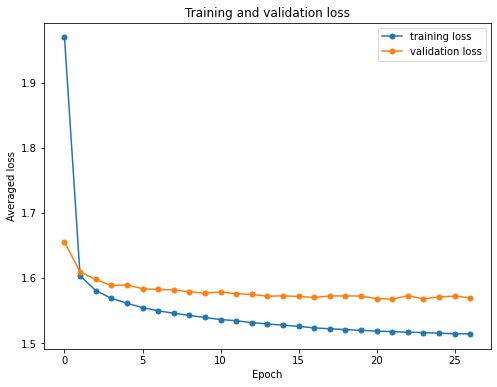

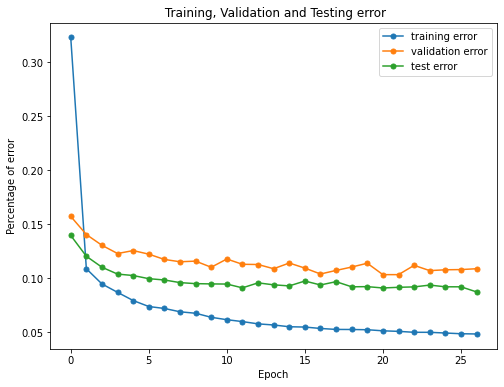

In [ ]:
m_2_layers = Network()
print(m_2_layers)
print(m_2_layers.parameters())

m_2_layers, m_2_layers_data = train(m_2_layers, lr= 0.1, epochs= 1000 , stop_threshold = 5,
                          train_data=train_loader, val_data=val_loader, test_data=test_loader,
                          PATH = '/content/models/m_2_layers-0.1.py',
                          cal_error_train=True, cal_test_data=True)



#print the errors when stopped
print("Final vaidation error {}".format(m_2_layers_data[3][len(m_2_layers_data[0])-1]))

#plots
plotting(m_2_layers_data, 'Training and validation loss', ' Training, Validation and Testing error', train_error=True, test_error=True)

#Testing
accuracy = 0
for images, labels in test_loader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    images = images.view(images.shape[0], -1)
    output =m_2_layers(images)
    accuracy += get_acc(output, labels)

print("Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Final vaidation error: 0.10878908634185791

In [ ]:
#Testing
accuracy = 0
for images, labels in test_loader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    images = images.view(images.shape[0], -1)
    output =m_2_layers(images)
    accuracy += get_acc(output, labels)
print("two layer Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

#Testing
accuracy = 0
for images, labels in test_loader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    images = images.view(images.shape[0], -1)
    output =m1(images)
    accuracy += get_acc(output, labels)
print("one layer Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

two layer Test Accuracy: 0.913
one layer Test Accuracy: 0.912


The above cell has been repeated for many times
A slightly better test accuracy was found for two layer structure

# Task V dropout

Network(
  (hidden): Linear(in_features=784, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (drop): Dropout(p=0.5, inplace=False)
)
<generator object Module.parameters at 0x7fbbeb0dfa50>
Epoch: 1 	Training loss: 1.692570	 Valid accuracy: 0.8646484613418579	 test accuracy: 0.8823630809783936
Time on epoch:  0.7263722009993216
Epoch: 2 	Training loss: 1.584138	 Valid accuracy: 0.8773437738418579	 test accuracy: 0.8872016072273254
Time on epoch:  0.7363649910003005
Epoch: 3 	Training loss: 1.570050	 Valid accuracy: 0.883007824420929	 test accuracy: 0.8913134932518005
Time on epoch:  0.7033928110004126
Epoch: 4 	Training loss: 1.561042	 Valid accuracy: 0.8833984136581421	 test accuracy: 0.901755690574646
Time on epoch:  0.7114460020002298
Epoch: 5 	Training loss: 1.555486	 Valid accuracy: 0.886914074420929	 test accuracy: 0.9028457999229431
Time on epoch:  0.718577854000614
Epoch: 6 	Training los

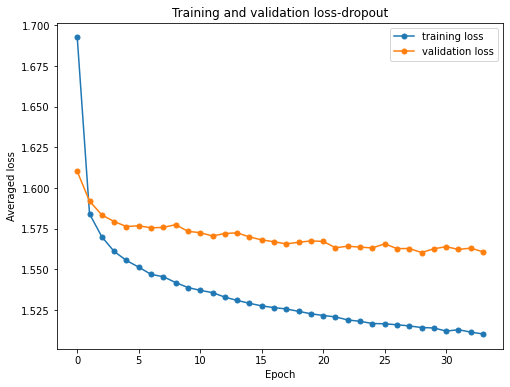

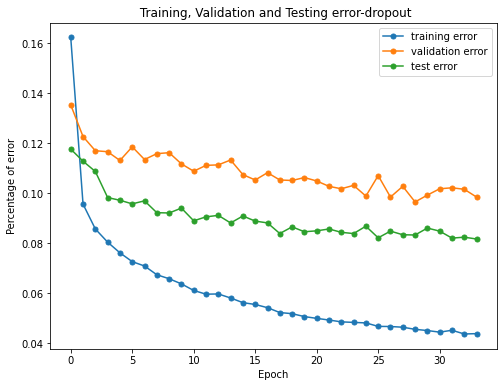

In [ ]:
m_dropout = Network()
print(m_dropout)
print(m_dropout.parameters())

m_dropout, m_dropout_data = train(m_dropout, lr= 0.2, epochs= 1000 , stop_threshold = 5,
                          train_data=train_loader, val_data=val_loader, test_data=test_loader,
                          PATH = '/content/models/m_dropout-0.2.py',
                          cal_error_train=True, cal_test_data=True)

#print the errors when stopped
print("Training error: {}, validatoin error: {}, test error: {}".format(m1_data[2][len(m1_data[0])-1], m1_data[3][len(m1_data[0])-1],m1_data[4][len(m1_data[0])-1]))

#plots
plotting(m_dropout_data, 'Training and validation loss-dropout', ' Training, Validation and Testing error-dropout', train_error=True, test_error=True)

#Testing
accuracy = 0
for images, labels in test_loader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    images = images.view(images.shape[0], -1)
    output = m_dropout(images)
    accuracy += get_acc(output, labels)

print("Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Dropout brings more fluctuation on validation error and test error during training, but have better final accuracy than the structure without dropput.

# Save and load the model to resume training
the following code is from pytorch documentation

save

In [ ]:
PATH = '/content/models/testing.tar'
num_epoch = 20
torch.save({
            'epochs': num_epoch,
            'model_state_dict': model2.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 1.509116
            }, PATH)

load

In [ ]:
model2 = Network()
optimizer = optim.SGD(model2.parameters(), lr=0.1)

checkpoint = torch.load(PATH)
model2.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epochs']
loss = checkpoint['loss']

#model.eval()
# - or -
#model.train()

In [ ]:
model2, model_data = train(model2, 0.01, epochs= 10 ,
                          train_data=train_loader, val_data=val_loader, test_data=test_loader,
                          cal_error_train=False, cal_test_data=True)

In [ ]:
print(loss)
print(epoch)

1.497134
20


A trial code for testing 

In [ ]:
accuracy = 0
model = m1

for images, labels in test_loader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    images = images.view(images.shape[0], -1)
    log_ps = model(images)

    # get the predictions: argmax etc.
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))

        
print("Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Test Accuracy: 0.910
